<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor, Pool, MetricVisualizer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from math import sqrt
import datetime

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим временной рад на монотонность и наличие пропусков

In [4]:
df.index.is_monotonic

True

In [5]:
df.num_orders.isna().sum()

0

<AxesSubplot:>

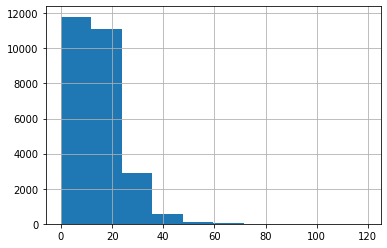

In [6]:
df['num_orders'].hist()

## Анализ

In [7]:
df=df.resample('1H').sum()

Разложим ряд на тренд, сезонную составляющую и остаточный шум.

In [8]:
decomposed = seasonal_decompose(df)

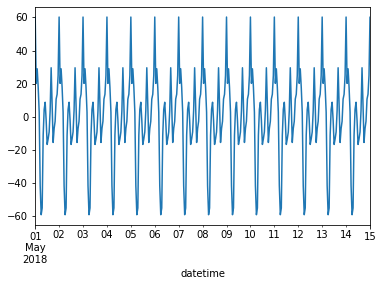

In [9]:
decomposed.seasonal.plot()
ax = plt.gca()
ax.set_xlim(['2018-05-01', '2018-05-15'])
plt.show()

<AxesSubplot:xlabel='datetime'>

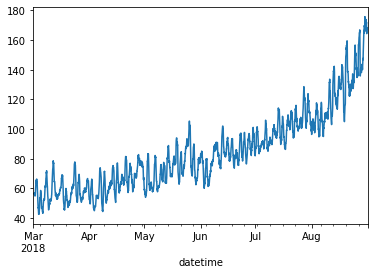

In [10]:
decomposed.trend.plot()

<AxesSubplot:xlabel='datetime'>

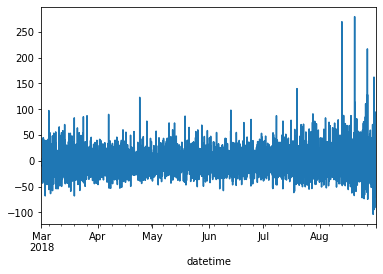

In [11]:
decomposed.resid.plot()

Отмечается выраженная суточная сезонность и постоянный тренд роста количества заказов. В остатке декомпозиции можно отметить наличие выбросов. Бросаются в глаза пики роста на в конце августа.

## Обучение

Напишем функцию, которая добавляет уточняющие столбцы с датой и временем, столбцы с отстающими значениями и столбец со скользящим средним.

In [12]:
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour    
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

На линейной модели определим, какое количество столбоц с отстающими значеними и какой размер скользящего окна оптимальны для обучения

In [13]:
%%time
best_rmse = 1000
for max_lag in range(5, 201, 5):
    for rolling_mean_size in range(10, 101, 10):
        df_changed = make_features(df, max_lag, rolling_mean_size)
        df_changed = df_changed.dropna()
        features = df_changed.drop('num_orders', axis=1)
        target = df_changed['num_orders']
        features_train, features_, target_train, target_ = train_test_split(features, target, test_size=.2, shuffle=False)
        features_valid, features_test, target_valid, target_test = train_test_split(features_, target_, test_size=.5, shuffle=False)
        model = LinearRegression()
        model.fit(features_train, target_train)
        if rmse(target_valid, model.predict(features_valid)) < best_rmse:
            best_rmse = rmse(target_valid, model.predict(features_valid))
            best_linear_model = model
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            best_df = df_changed
print('Оптимальное количество столбцов с отстающими значениями:', best_lag)
print('Оптимальный размер скользящего окна:', best_rolling_mean_size)

Оптимальное количество столбцов с отстающими значениями: 195
Оптимальный размер скользящего окна: 50
CPU times: user 1min 38s, sys: 1min 34s, total: 3min 12s
Wall time: 3min 12s


Сохраним полученные оптимальные параметры временного ряда и поделиим датафрейм на обучающую, валидационную и тестовую выборки.

In [16]:
df = best_df
features = df.drop('num_orders', axis=1)
target = df['num_orders']
features_train, features_, target_train, target_ = train_test_split(features, target, test_size=.2, shuffle=False)
features_valid, features_test, target_valid, target_test = train_test_split(features_, target_, test_size=.5, shuffle=False)

Проверим работу разных моделей

### LinearRegression

In [15]:
print('Наилучший RMSE линейной модели на валидационной выборке составил {:.1f}'.format(best_rmse))

Наилучший RMSE линейной модели на валидационной выборке составил 29.0


### RandomForestRegressor

In [20]:
%%time
best_forest_rmse = 1000
for n_estimators in [10, 50, 100]:
    for max_depth in [1, 10, 20]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        model.fit(features_train, target_train)
        rmse_valid = rmse(target_valid, model.predict(features_valid))
        if rmse_valid < best_forest_rmse:
            best_forest_rmse = rmse_valid
            best_forest_model = model
            best_forest_estimators = n_estimators
            best_forest_depth = max_depth
print('Лучший результат на валидационной выборке составил {:.1f}'.format(best_forest_rmse))
print(f'Оптимальные гиперпараметры модели: {best_forest_estimators} деревьев при глубине {best_forest_depth}')

Лучший результат на валидационной выборке составил 30.0
Оптимальные гиперпараметры модели: 50 деревьев при глубине 20
CPU times: user 1min 32s, sys: 0 ns, total: 1min 32s
Wall time: 1min 32s


In [21]:
valid_rmse_forest = rmse(target_valid, model.predict(features_valid))
print('RMSE модели CatBoost на тестовой выборке составил {:.1f}'.format(valid_rmse_forest))

RMSE модели CatBoost на тестовой выборке составил 30.1


### CatBoost

In [22]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', random_seed=1, iterations=150, 
                             learning_rate=0.03, depth=10, use_best_model=True, eval_metric='RMSE')
model_cb.fit(features_train, target_train,
          eval_set=(features_valid, target_valid),
          verbose=False)

CPU times: user 48.4 s, sys: 0 ns, total: 48.4 s
Wall time: 49.2 s


In [23]:
valid_rmse_cb = rmse(target_valid, model_cb.predict(features_valid))
print('RMSE модели CatBoost на тестовой выборке составил {:.1f}'.format(valid_rmse_cb))

RMSE модели CatBoost на тестовой выборке составил 32.2


### XGBoost

In [24]:
%%time
model_xgb = XGBRegressor(learning_rate=0.03, n_estimators=200, seed=1, max_depth=15)
model_xgb.fit(features_train, target_train)

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
valid_rmse_xgb = rmse(target_valid, model_xgb.predict(features_valid))
print('RMSE модели XGBoost на тестовой выборке составил {:.1f}'.format(valid_rmse_xgb))

RMSE модели XGBoost на тестовой выборке составил 32.5


## Вывод

Объединим результаты работы разных моделей в один датафрейм

In [26]:
results = pd.DataFrame({'Models':['LinearRegression', 'RandomForestRegressor', 'CatBoost', 'XGBoost'],
                        'RMSE': [best_rmse, valid_rmse_forest, valid_rmse_cb, valid_rmse_xgb]})
display(results)

,Models,RMSE
0,LinearRegression,28.955884
1,RandomForestRegressor,30.108124
2,CatBoost,32.210563
3,XGBoost,32.524306


Лучше всего себя показала модель линейной регрессии. Вероятно, это связано с устойчивым трендом роста заказов на протяжении всего периода времени. Модели случайного леса и градиентного бустинга показали слабый результат.

Визуализируем эффективность модели линейной регрессии.

In [17]:
test_rmse_linear = rmse(target_test, best_linear_model.predict(features_test))
print('RMSE модели линейной на тестовой выборке составил {:.1f}'.format(test_rmse_linear))

RMSE модели линейной на тестовой выборке составил 34.4


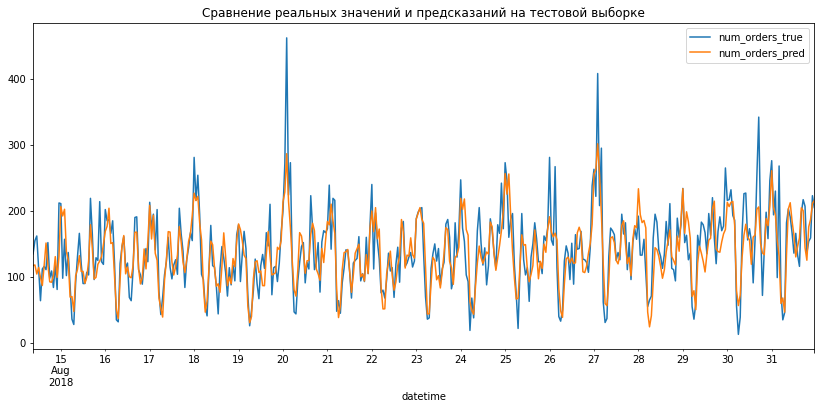

In [19]:
linear_results = pd.DataFrame({'num_orders_true':target_test,
                               'num_orders_pred':best_linear_model.predict(features_test)})
linear_results.plot(figsize=(14,6), title='Сравнение реальных значений и предсказаний на тестовой выборке');

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48